# 0. Load libraries

In [121]:
import pandas as pd
import numpy as np
import modeling_functions as mf
from tqdm import tqdm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
import warnings
warnings.filterwarnings("ignore")
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler

# Prices
print("Loading prices data...")
url = 'https://drive.google.com/uc?id=1P_5ykYLd5521QUdCxC_cMytdJ3PqESTw'
prices = pd.read_csv("prices.csv", parse_dates=True, index_col=0)
print("✓ Loaded prices")

Loading prices data...
✓ Loaded prices


In [69]:
prices.head(10)

,coin,open,high,low,close,volume
date,,,,,,
2018-01-01 01:00:00,BTC,13791.4,13804.9,13680.0,13680.0,5.922596
2018-01-01 02:00:00,BTC,13500.4,13600.0,13480.0,13514.0,9.326084
2018-01-01 03:00:00,BTC,13512.0,13576.4,13512.0,13560.2,11.704644
2018-01-01 04:00:00,BTC,13694.8,13809.8,13667.4,13667.4,17.126073
2018-01-01 05:00:00,BTC,13763.3,13887.9,13658.6,13765.0,9.322753
2018-01-01 06:00:00,BTC,13781.2,13849.4,13747.0,13747.0,26.133538
2018-01-01 07:00:00,BTC,14108.4,14224.0,14099.0,14168.7,12.534892
2018-01-01 08:00:00,BTC,13950.1,14120.4,13901.1,13922.1,9.495752
2018-01-01 09:00:00,BTC,13742.7,13884.0,13742.7,13785.0,6.781434


In [72]:
trial = prices.copy()

trial['return'] = trial['close']/trial['close'].shift(1)-1
trial.head(10)

,coin,open,high,low,close,volume,return
date,,,,,,,
2018-01-01 01:00:00,BTC,13791.4,13804.9,13680.0,13680.0,5.922596,NaN
2018-01-01 02:00:00,BTC,13500.4,13600.0,13480.0,13514.0,9.326084,-0.012135
2018-01-01 03:00:00,BTC,13512.0,13576.4,13512.0,13560.2,11.704644,0.003419
2018-01-01 04:00:00,BTC,13694.8,13809.8,13667.4,13667.4,17.126073,0.007905
2018-01-01 05:00:00,BTC,13763.3,13887.9,13658.6,13765.0,9.322753,0.007141
2018-01-01 06:00:00,BTC,13781.2,13849.4,13747.0,13747.0,26.133538,-0.001308
2018-01-01 07:00:00,BTC,14108.4,14224.0,14099.0,14168.7,12.534892,0.030676
2018-01-01 08:00:00,BTC,13950.1,14120.4,13901.1,13922.1,9.495752,-0.017405
2018-01-01 09:00:00,BTC,13742.7,13884.0,13742.7,13785.0,6.781434,-0.009848


# 1. Feature Engineering

    return_format : str, default 'features_only'
    'features_only' - Return only the 6 volatility feature columns as DataFrame
    'with_original' - Return original data + volatility features as DataFrame  
    'both' - Return (full_df, features_df) tuple

#### Group 1: EMA Moving Average

In [63]:
def create_ema_features(df, price_col='close', return_format='features_only'):
    
    # Copy the dataframe to avoid modifying original
    result_df = df.copy()
    
    # Validate input
    if price_col not in df.columns:
        raise ValueError(f"Column '{price_col}' not found in dataframe")
    
    if df[price_col].isnull().all():
        raise ValueError(f"Column '{price_col}' contains only null values")
    
    print("Creating EMA features...")
    
    # Calculate EMAs optimized for Bitcoin 24/7 cycles
    # 6hr = Quarter day (major session transitions)
    # 12hr = Half day (day vs night cycles)  
    # 24hr = Full day (daily sentiment)
    
    result_df['ema_6hr'] = df[price_col].ewm(span=6, adjust=False).mean()
    result_df['ema_12hr'] = df[price_col].ewm(span=12, adjust=False).mean()  
    result_df['ema_24hr'] = df[price_col].ewm(span=24, adjust=False).mean()
    
    # Calculate EMA ratios - these capture trend relationships
    # Values > 1.0 = shorter EMA above longer EMA (bullish)
    # Values < 1.0 = shorter EMA below longer EMA (bearish)
    
    # Short vs daily trend (most sensitive)
    result_df['ema_6_24_ratio'] = result_df['ema_6hr'] / result_df['ema_24hr']
    
    # Medium vs daily trend (trend confirmation)  
    result_df['ema_12_24_ratio'] = result_df['ema_12hr'] / result_df['ema_24hr']
    
    # Short vs medium trend (momentum detection)
    result_df['ema_6_12_ratio'] = result_df['ema_6hr'] / result_df['ema_12hr']
    
    # Handle edge cases where division by zero might occur
    result_df['ema_6_24_ratio'] = result_df['ema_6_24_ratio'].replace([np.inf, -np.inf], np.nan)
    result_df['ema_12_24_ratio'] = result_df['ema_12_24_ratio'].replace([np.inf, -np.inf], np.nan) 
    result_df['ema_6_12_ratio'] = result_df['ema_6_12_ratio'].replace([np.inf, -np.inf], np.nan)
    
    # Define the final feature columns we want
    ema_feature_columns = [
        'ema_6_24_ratio',
        'ema_12_24_ratio', 
        'ema_6_12_ratio'
    ]
    
    print(f"✓ Created {len(ema_feature_columns)} EMA features")
    print(f"✓ Features: {ema_feature_columns}")
    
    # Print some basic statistics
    print("\nEMA Feature Statistics:")
    for feature in ema_feature_columns:
        valid_count = result_df[feature].notna().sum()
        mean_val = result_df[feature].mean()
        print(f"  {feature}: {valid_count} valid values, mean = {mean_val:.4f}")
    
    # Return based on requested format
    if return_format == 'features_only':
        # Return only the 3 EMA features as DataFrame
        features_df = result_df[ema_feature_columns].copy()
        features_df.index = df.index  # Preserve original index
        return features_df
        
    elif return_format == 'with_original':
        # Return original data + EMA features
        return result_df
        
    elif return_format == 'both':
        # Return both full DataFrame and features-only DataFrame
        features_df = result_df[ema_feature_columns].copy()
        features_df.index = df.index
        return result_df, features_df
        
    else:
        raise ValueError("return_format must be 'features_only', 'with_original', or 'both'")

In [64]:
prices_f1_ewm = create_ema_features(prices)


Creating EMA features...
✓ Created 3 EMA features
✓ Features: ['ema_6_24_ratio', 'ema_12_24_ratio', 'ema_6_12_ratio']

EMA Feature Statistics:
  ema_6_24_ratio: 54496 valid values, mean = 1.0002
  ema_12_24_ratio: 54496 valid values, mean = 1.0001
  ema_6_12_ratio: 54496 valid values, mean = 1.0001


In [65]:
prices_f1_ewm

,ema_6_24_ratio,ema_12_24_ratio,ema_6_12_ratio
date,,,
2018-01-01 01:00:00,1.000000,1.000000,1.000000
2018-01-01 02:00:00,0.997501,0.999103,0.998397
2018-01-01 03:00:00,0.996610,0.998665,0.997942
2018-01-01 04:00:00,0.997717,0.998920,0.998796
2018-01-01 05:00:00,0.999967,0.999660,1.000307
...,...,...,...
2024-03-20 12:00:00,0.995965,0.994063,1.001913
2024-03-20 13:00:00,0.998564,0.995498,1.003080
2024-03-20 14:00:00,1.000633,0.996788,1.003858


#### Group 2: Volatility

In [100]:
def create_volatility_features(df, price_col='close', high_col='high', low_col='low', return_format='features_only'):
    
    # Copy the dataframe to avoid modifying original
    result_df = df.copy()
    
    # Validate input columns
    required_cols = [price_col, high_col, low_col]
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    for col in required_cols:
        if df[col].isnull().all():
            raise ValueError(f"Column '{col}' contains only null values")
    
    print("Creating volatility features...")
    
    # Calculate returns for volatility calculations
    
    returns = df[price_col]/df[price_col].shift(1)-1
    result_df['last_price_change'] = returns
    
    # Feature 1: 4-hour volatility (short-term risk)
    result_df['vol_4hr'] = returns.rolling(window=4, min_periods=4).std()
    
    # Feature 2: 24-hour volatility (daily risk)
    result_df['vol_24hr'] = returns.rolling(window=24, min_periods=24).std()
    
    # Feature 3: Average True Range (ATR_6) - measures price movement volatility
    # True Range = max(high-low, abs(high-prev_close), abs(low-prev_close))
    prev_close = df[price_col].shift(1)
    tr1 = df[high_col] - df[low_col]  # High - Low
    tr2 = np.abs(df[high_col] - prev_close)  # |High - Previous Close|
    tr3 = np.abs(df[low_col] - prev_close)   # |Low - Previous Close|
    
    true_range = np.maximum(tr1, np.maximum(tr2, tr3))
    result_df['atr_6'] = true_range.rolling(window=6, min_periods=6).mean()
    
    # Feature 4: Bollinger Band Width (volatility expansion/contraction)
    # BB Width = (Upper Band - Lower Band) / Middle Band
    bb_period = 20
    bb_std = 2
    
    bb_middle = df[price_col].rolling(window=bb_period, min_periods=20).mean()
    bb_std_dev = df[price_col].rolling(window=bb_period, min_periods=20).std()
    bb_upper = bb_middle + (bb_std_dev * bb_std)
    bb_lower = bb_middle - (bb_std_dev * bb_std)
    
    # Avoid division by zero
    result_df['bb_bandwidth'] = np.where(
        bb_middle != 0,
        (bb_upper - bb_lower) / bb_middle,
        np.nan
    )
    
    # Feature 5: 4hr/24hr volatility ratio (short vs long-term volatility regime)
    result_df['vol_4hr_24hr_ratio'] = np.where(
        result_df['vol_24hr'] != 0,
        result_df['vol_4hr'] / result_df['vol_24hr'],
        np.nan
    )
    
    # Feature 6: Current hour range / 12hr average range (current vs recent range)
    # Current hour range
    current_range = (df[high_col] - df[low_col]) / df[price_col]  # Normalized by price
    
    # 12-hour average range  
    avg_range_12hr = current_range.rolling(window=12, min_periods=12).mean()
    
    result_df['range_1hr_12hr_ratio'] = np.where(
        avg_range_12hr != 0,
        current_range / avg_range_12hr,
        np.nan
    )
    
    # Handle infinite values and extreme outliers
    volatility_features = [
        'last_price_change',
        'vol_4hr',
        'vol_24hr', 
        'atr_6',
        'bb_bandwidth',
        'vol_4hr_24hr_ratio',
        'range_1hr_12hr_ratio'
    ]
    
    for feature in volatility_features:
        # Replace infinities with NaN
        result_df[feature] = result_df[feature].replace([np.inf, -np.inf], np.nan)
    
    print(f"✓ Created {len(volatility_features)} volatility features")
    print(f"✓ Features: {volatility_features}")
    
    # Print some basic statistics
    print("\nVolatility Feature Statistics:")
    for feature in volatility_features:
        valid_count = result_df[feature].notna().sum()
        if valid_count > 0:
            mean_val = result_df[feature].mean()
            std_val = result_df[feature].std()
            print(f"  {feature}: {valid_count} valid values, mean = {mean_val:.6f}, std = {std_val:.6f}")
        else:
            print(f"  {feature}: No valid values")
    
    
    
    
    
    # Return based on requested format
    if return_format == 'features_only':
        # Return only the 6 volatility features as DataFrame
        features_df = result_df[volatility_features].copy()
        features_df.index = df.index  # Preserve original index
        return features_df
        
    elif return_format == 'with_original':
        # Return original data + volatility features
        return result_df
        
    elif return_format == 'both':
        # Return both full DataFrame and features-only DataFrame
        features_df = result_df[volatility_features].copy()
        features_df.index = df.index
        return result_df, features_df
        
    else:
        raise ValueError("return_format must be 'features_only', 'with_original', or 'both'")
    
    




In [ ]:
prices_f2_volatility = create_volatility_features(prices,return_format='with_original')

Creating volatility features...
✓ Created 7 volatility features
✓ Features: ['last_price_change', 'vol_4hr', 'vol_24hr', 'atr_6', 'bb_bandwidth', 'vol_4hr_24hr_ratio', 'range_1hr_12hr_ratio']

Volatility Feature Statistics:
  last_price_change: 54495 valid values, mean = 0.000061, std = 0.008048
  vol_4hr: 54492 valid values, mean = 0.005673, std = 0.005897
  vol_24hr: 54472 valid values, mean = 0.006472, std = 0.004814
  atr_6: 54490 valid values, mean = 159.471125, std = 188.728379
  bb_bandwidth: 54477 valid values, mean = 0.042037, std = 0.037380
  vol_4hr_24hr_ratio: 54471 valid values, mean = 0.886238, std = 0.485572
  range_1hr_12hr_ratio: 54439 valid values, mean = 1.014214, std = 0.720576


In [ ]:
prices_f2_volatility.head(20)

,coin,open,high,low,close,volume,last_price_change,vol_4hr,vol_24hr,atr_6,bb_bandwidth,vol_4hr_24hr_ratio,range_1hr_12hr_ratio
date,,,,,,,,,,,,,
2018-01-01 01:00:00,BTC,13791.4,13804.9,13680.0,13680.0,5.922596,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 02:00:00,BTC,13500.4,13600.0,13480.0,13514.0,9.326084,-0.012135,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 03:00:00,BTC,13512.0,13576.4,13512.0,13560.2,11.704644,0.003419,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 04:00:00,BTC,13694.8,13809.8,13667.4,13667.4,17.126073,0.007905,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 05:00:00,BTC,13763.3,13887.9,13658.6,13765.0,9.322753,0.007141,0.009352,NaN,NaN,NaN,NaN,NaN
2018-01-01 06:00:00,BTC,13781.2,13849.4,13747.0,13747.0,26.133538,-0.001308,0.004215,NaN,NaN,NaN,NaN,NaN
2018-01-01 07:00:00,BTC,14108.4,14224.0,14099.0,14168.7,12.534892,0.030676,0.013700,NaN,220.450000,NaN,NaN,NaN
2018-01-01 08:00:00,BTC,13950.1,14120.4,13901.1,13922.1,9.495752,-0.017405,0.020045,NaN,231.716667,NaN,NaN,NaN
2018-01-01 09:00:00,BTC,13742.7,13884.0,13742.7,13785.0,6.781434,-0.009848,0.021146,NaN,250.883333,NaN,NaN,NaN


#### Group 3: Momentum

In [103]:
def create_momentum_features(df, price_col='close', high_col='high', low_col='low', return_format='features_only'):

    # Copy the dataframe to avoid modifying original
    result_df = df.copy()
    
    # Validate input columns
    required_cols = [price_col, high_col, low_col]
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    for col in required_cols:
        if df[col].isnull().all():
            raise ValueError(f"Column '{col}' contains only null values")
    
    print("Creating momentum features...")
    
    # Calculate basic returns for momentum calculations
    returns = df[price_col].pct_change()
    
    # Feature 1: RSI_14 (Relative Strength Index - mean reversion indicator)
    # RSI measures momentum, ranges 0-100, >70 overbought, <30 oversold
    def calculate_rsi(prices, window=14):
        delta = prices.diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        
        # Use full window for quality (conservative approach)
        avg_gain = gain.rolling(window=window, min_periods=window).mean()
        avg_loss = loss.rolling(window=window, min_periods=window).mean()
        
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi
    
    result_df['rsi_14'] = calculate_rsi(df[price_col], window=14)
    
    # Feature 2: MACD Histogram normalized by ATR
    # MACD shows relationship between two moving averages, histogram shows momentum
    def calculate_macd_hist_atr(prices, high, low, fast=12, slow=26, signal=9, atr_period=14):
        # Calculate EMAs for MACD
        ema_fast = prices.ewm(span=fast).mean()
        ema_slow = prices.ewm(span=slow).mean()
        
        # MACD line
        macd_line = ema_fast - ema_slow
        
        # Signal line
        signal_line = macd_line.ewm(span=signal).mean()
        
        # MACD Histogram
        macd_hist = macd_line - signal_line
        
        # Calculate ATR for normalization
        prev_close = prices.shift(1)
        tr1 = high - low
        tr2 = np.abs(high - prev_close)
        tr3 = np.abs(low - prev_close)
        true_range = np.maximum(tr1, np.maximum(tr2, tr3))
        atr = true_range.rolling(window=atr_period, min_periods=atr_period).mean()
        
        # Normalize MACD histogram by ATR
        macd_hist_normalized = np.where(atr != 0, macd_hist / atr, np.nan)
        
        return macd_hist_normalized
    
    result_df['macd_hist_atr'] = calculate_macd_hist_atr(
        df[price_col], df[high_col], df[low_col]
    )
    
    # Feature 3: 6-hour return (short-medium term momentum)
    # Shows price momentum over a 6-hour period
    result_df['return_6hr'] = returns.rolling(window=6, min_periods=6).apply(
        lambda x: (1 + x).prod() - 1
    )
    
    # Feature 4: 12-hour return (medium term momentum) 
    # Shows price momentum over a 12-hour period
    result_df['return_12hr'] = returns.rolling(window=12, min_periods=12).apply(
        lambda x: (1 + x).prod() - 1
    )
    
    # Define momentum features list
    momentum_features = [
        'rsi_14',
        'macd_hist_atr',
        'return_6hr',
        'return_12hr'
    ]
    
    # Handle infinite values (but no outlier capping for momentum features)
    for feature in momentum_features:
        # Replace infinities with NaN
        result_df[feature] = result_df[feature].replace([np.inf, -np.inf], np.nan)
    
    print(f"✓ Created {len(momentum_features)} momentum features")
    print(f"✓ Features: {momentum_features}")
    print("✓ Using full windows for maximum statistical quality")
    print("✓ Features available: rsi_14 (hour 14+), macd_hist_atr (hour 26+), return_6hr (hour 6+), return_12hr (hour 12+)")
    
    # Print some basic statistics
    print("\nMomentum Feature Statistics:")
    for feature in momentum_features:
        valid_count = result_df[feature].notna().sum()
        if valid_count > 0:
            mean_val = result_df[feature].mean()
            std_val = result_df[feature].std()
            min_val = result_df[feature].min()
            max_val = result_df[feature].max()
            print(f"  {feature}: {valid_count} valid values, mean = {mean_val:.6f}, std = {std_val:.6f}")
            print(f"    Range: [{min_val:.6f}, {max_val:.6f}]")
        else:
            print(f"  {feature}: No valid values")
    
    # Return based on requested format
    if return_format == 'features_only':
        # Return only the 4 momentum features as DataFrame
        features_df = result_df[momentum_features].copy()
        features_df.index = df.index  # Preserve original index
        return features_df
        
    elif return_format == 'with_original':
        # Return original data + momentum features
        return result_df
        
    elif return_format == 'both':
        # Return both full DataFrame and features-only DataFrame
        features_df = result_df[momentum_features].copy()
        features_df.index = df.index
        return result_df, features_df
        
    else:
        raise ValueError("return_format must be 'features_only', 'with_original', or 'both'")


In [104]:
prices_f3_mom = create_momentum_features(prices)

Creating momentum features...
✓ Created 4 momentum features
✓ Features: ['rsi_14', 'macd_hist_atr', 'return_6hr', 'return_12hr']
✓ Using full windows for maximum statistical quality
✓ Features available: rsi_14 (hour 14+), macd_hist_atr (hour 26+), return_6hr (hour 6+), return_12hr (hour 12+)

Momentum Feature Statistics:
  rsi_14: 54466 valid values, mean = 50.785845, std = 16.614146
    Range: [0.000000, 100.000000]
  macd_hist_atr: 54465 valid values, mean = 0.004887, std = 0.309872
    Range: [-1.344237, 3.244618]
  return_6hr: 54490 valid values, mean = 0.000341, std = 0.018469
    Range: [-0.303808, 0.324659]
  return_12hr: 54484 valid values, mean = 0.000670, std = 0.025822
    Range: [-0.296238, 0.369890]


In [105]:
prices_f3_mom.head(20)

,rsi_14,macd_hist_atr,return_6hr,return_12hr
date,,,,
2018-01-01 01:00:00,NaN,NaN,NaN,NaN
2018-01-01 02:00:00,NaN,NaN,NaN,NaN
2018-01-01 03:00:00,NaN,NaN,NaN,NaN
2018-01-01 04:00:00,NaN,NaN,NaN,NaN
2018-01-01 05:00:00,NaN,NaN,NaN,NaN
2018-01-01 06:00:00,NaN,NaN,NaN,NaN
2018-01-01 07:00:00,NaN,NaN,0.035724,NaN
2018-01-01 08:00:00,NaN,NaN,0.030198,NaN
2018-01-01 09:00:00,NaN,NaN,0.016578,NaN


#### Group 4: Volume

In [106]:
def create_volume_features(df, price_col='close', high_col='high', low_col='low', volume_col='volume', return_format='features_only'):
   
    # Copy the dataframe to avoid modifying original
    result_df = df.copy()
    
    # Validate input columns
    required_cols = [price_col, high_col, low_col, volume_col]
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    for col in required_cols:
        if df[col].isnull().all():
            raise ValueError(f"Column '{col}' contains only null values")
    
    print("Creating volume features...")
    
    # Feature 1: Volume Ratio 24hr (volume strength vs recent average)
    # Shows whether current trading activity is above or below normal
    volume_24hr_avg = df[volume_col].rolling(window=24, min_periods=24).mean()
    result_df['volume_ratio_24'] = np.where(
        volume_24hr_avg != 0,
        df[volume_col] / volume_24hr_avg,
        np.nan
    )
    
    # Feature 2: Volume Rate of Change 6-period (volume momentum)
    # Shows the 6-period rate of change in trading volume
    def calculate_volume_roc(volume, periods=6):
        volume_shifted = volume.shift(periods)
        roc = np.where(
            volume_shifted != 0,
            (volume - volume_shifted) / volume_shifted,
            np.nan
        )
        return roc
    
    result_df['volume_roc6'] = calculate_volume_roc(df[volume_col], periods=6)
    
    # Feature 3: VWAP Distance (price vs volume-weighted average price)
    # Shows whether price is trading above or below the volume-weighted average
    def calculate_vwap_distance(prices, highs, lows, volumes, window=24):
        # Calculate typical price
        typical_price = (highs + lows + prices) / 3
        
        # Calculate VWAP using rolling window
        vwap_numerator = (typical_price * volumes).rolling(window=window, min_periods=window).sum()
        vwap_denominator = volumes.rolling(window=window, min_periods=window).sum()
        
        vwap = np.where(vwap_denominator != 0, vwap_numerator / vwap_denominator, np.nan)
        
        # Calculate distance from VWAP as percentage
        vwap_distance = np.where(vwap != 0, (prices - vwap) / vwap, np.nan)
        
        return vwap_distance
    
    result_df['vwap_distance'] = calculate_vwap_distance(
        df[price_col], df[high_col], df[low_col], df[volume_col], window=24
    )
    
    # Define volume features list
    volume_features = [
        'volume_ratio_24',
        'volume_roc6',
        'vwap_distance'
    ]
    
    # Handle infinite values (NO outlier capping - learned from volatility issue)
    for feature in volume_features:
        # Replace infinities with NaN (SAFE - no data corruption)
        result_df[feature] = result_df[feature].replace([np.inf, -np.inf], np.nan)
    
    print(f"✓ Created {len(volume_features)} volume features")
    print(f"✓ Features: {volume_features}")
    print("✓ Using full windows for maximum statistical quality")
    print("✓ Features available: volume_ratio_24 (hour 24+), volume_roc6 (hour 6+), vwap_distance (hour 24+)")
    print("✓ NO outlier capping - preserves all legitimate volume data")
    
    # Print some basic statistics
    print("\nVolume Feature Statistics:")
    for feature in volume_features:
        valid_count = result_df[feature].notna().sum()
        if valid_count > 0:
            mean_val = result_df[feature].mean()
            std_val = result_df[feature].std()
            min_val = result_df[feature].min()
            max_val = result_df[feature].max()
            print(f"  {feature}: {valid_count} valid values, mean = {mean_val:.6f}, std = {std_val:.6f}")
            print(f"    Range: [{min_val:.6f}, {max_val:.6f}]")
        else:
            print(f"  {feature}: No valid values")
    
    # Return based on requested format
    if return_format == 'features_only':
        # Return only the 3 volume features as DataFrame
        features_df = result_df[volume_features].copy()
        features_df.index = df.index  # Preserve original index
        return features_df
        
    elif return_format == 'with_original':
        # Return original data + volume features
        return result_df
        
    elif return_format == 'both':
        # Return both full DataFrame and features-only DataFrame
        features_df = result_df[volume_features].copy()
        features_df.index = df.index
        return result_df, features_df
        
    else:
        raise ValueError("return_format must be 'features_only', 'with_original', or 'both'")



In [107]:
prices_f4_volume = create_volume_features(prices)

Creating volume features...
✓ Created 3 volume features
✓ Features: ['volume_ratio_24', 'volume_roc6', 'vwap_distance']
✓ Using full windows for maximum statistical quality
✓ Features available: volume_ratio_24 (hour 24+), volume_roc6 (hour 6+), vwap_distance (hour 24+)
✓ NO outlier capping - preserves all legitimate volume data

Volume Feature Statistics:
  volume_ratio_24: 54439 valid values, mean = 1.018813, std = 1.204012
    Range: [0.000000, 24.000000]
  volume_roc6: 54409 valid values, mean = 2.627158, std = 85.701977
    Range: [-1.000000, 17781.549357]
  vwap_distance: 54439 valid values, mean = 0.000840, std = 0.017530
    Range: [-0.269138, 0.146055]


In [109]:
prices_f4_volume.head(50)

,volume_ratio_24,volume_roc6,vwap_distance
date,,,
2018-01-01 01:00:00,NaN,NaN,NaN
2018-01-01 02:00:00,NaN,NaN,NaN
2018-01-01 03:00:00,NaN,NaN,NaN
2018-01-01 04:00:00,NaN,NaN,NaN
2018-01-01 05:00:00,NaN,NaN,NaN
2018-01-01 06:00:00,NaN,NaN,NaN
2018-01-01 07:00:00,NaN,1.116452,NaN
2018-01-01 08:00:00,NaN,0.018193,NaN
2018-01-01 09:00:00,NaN,-0.420620,NaN


#### Group 5: Price Action

In [116]:
def create_price_action_features(df, price_col='close', high_col='high', low_col='low', return_format='features_only'):

    # Copy the dataframe to avoid modifying original
    result_df = df.copy()
    
    # Validate input columns
    required_cols = [price_col, high_col, low_col]
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    for col in required_cols:
        if df[col].isnull().all():
            raise ValueError(f"Column '{col}' contains only null values")
    
    print("Creating price action features...")
    
    # Feature 1: Distance from 24hr high (support/resistance analysis)
    # Negative values = below recent high, shows how far from resistance
    rolling_high_24h = df[high_col].rolling(window=24, min_periods=24).max()
    result_df['dist_from_high_24h'] = np.where(
        df[price_col] != 0,
        (df[price_col] - rolling_high_24h) / df[price_col] * 100,
        np.nan
    )
    
    # Feature 2: Distance from 24hr low (support/resistance analysis)  
    # Positive values = above recent low, shows how far from support
    rolling_low_24h = df[low_col].rolling(window=24, min_periods=24).min()
    result_df['dist_from_low_24h'] = np.where(
        df[price_col] != 0,
        (df[price_col] - rolling_low_24h) / df[price_col] * 100,
        np.nan
    )
    
    # Feature 3: Bollinger Band Position (dynamic support/resistance)
    # 0.0 = at lower band, 1.0 = at upper band, 0.5 = at middle
    def calculate_bb_position(prices, window=20, std_dev=2):
        bb_middle = prices.rolling(window=window, min_periods=window).mean()
        bb_std = prices.rolling(window=window, min_periods=window).std()
        bb_upper = bb_middle + (bb_std * std_dev)
        bb_lower = bb_middle - (bb_std * std_dev)
        
        # Calculate position within bands (0-1 scale)
        bb_position = np.where(
            (bb_upper - bb_lower) != 0,
            (prices - bb_lower) / (bb_upper - bb_lower),
            np.nan
        )
        
        return bb_position
    
    result_df['bb_position'] = calculate_bb_position(df[price_col], window=20, std_dev=2)
    
    # Feature 4: Price acceleration 6hr (second derivative of price)
    # Shows whether momentum is accelerating or decelerating
    returns = df[price_col].pct_change()
    return_6h = returns.rolling(window=6, min_periods=6).apply(lambda x: (1 + x).prod() - 1)
    result_df['price_acceleration_6h'] = return_6h - return_6h.shift(6)
    
    # Feature 5: Higher highs count 12hr (trend strength analysis)
    # Counts how many times high > previous high in last 12 periods
    higher_highs = (df[high_col] > df[high_col].shift(1)).astype(int)
    result_df['higher_highs_12h'] = higher_highs.rolling(window=12, min_periods=12).sum()
    
    # Feature 6: Lower lows count 12hr (trend strength analysis)  
    # Counts how many times low < previous low in last 12 periods
    lower_lows = (df[low_col] < df[low_col].shift(1)).astype(int)
    result_df['lower_lows_12h'] = lower_lows.rolling(window=12, min_periods=12).sum()
    
    # Define price action features list
    price_action_features = [
        'dist_from_high_24h',
        'dist_from_low_24h',
        'bb_position',
        'price_acceleration_6h',
        'higher_highs_12h',
        'lower_lows_12h'
    ]
    
    # Handle infinite values (NO outlier capping - learned from previous issues)
    for feature in price_action_features:
        # Replace infinities with NaN (SAFE - no data corruption)
        result_df[feature] = result_df[feature].replace([np.inf, -np.inf], np.nan)
    
    print(f"✓ Created {len(price_action_features)} price action features")
    print(f"✓ Features: {price_action_features}")
    print("✓ Using full windows for maximum statistical quality")
    print("✓ Features available: dist_from_high/low_24h (hour 24+), bb_position (hour 20+), price_acceleration_6h (hour 12+), higher/lower_highs/lows_12h (hour 12+)")
    print("✓ NO outlier capping - preserves all legitimate price action signals")
    
    # Print some basic statistics
    print("\nPrice Action Feature Statistics:")
    for feature in price_action_features:
        valid_count = result_df[feature].notna().sum()
        if valid_count > 0:
            mean_val = result_df[feature].mean()
            std_val = result_df[feature].std()
            min_val = result_df[feature].min()
            max_val = result_df[feature].max()
            print(f"  {feature}: {valid_count} valid values, mean = {mean_val:.6f}, std = {std_val:.6f}")
            print(f"    Range: [{min_val:.6f}, {max_val:.6f}]")
            
            # Feature-specific interpretations
            if feature == 'bb_position':
                if 0.0 <= mean_val <= 1.0:
                    print(f"     ✓ BB position range is valid (0-1)")
                else:
                    print(f"     ⚠ BB position range seems unusual")
            elif 'higher_highs' in feature or 'lower_lows' in feature:
                if 0 <= mean_val <= 12:
                    print(f"     ✓ Count range is valid (0-12)")
                else:
                    print(f"     ⚠ Count range seems unusual")
        else:
            print(f"  {feature}: No valid values")
    
    # Return based on requested format
    if return_format == 'features_only':
        # Return only the 6 price action features as DataFrame
        features_df = result_df[price_action_features].copy()
        features_df.index = df.index  # Preserve original index
        return features_df
        
    elif return_format == 'with_original':
        # Return original data + price action features
        return result_df
        
    elif return_format == 'both':
        # Return both full DataFrame and features-only DataFrame
        features_df = result_df[price_action_features].copy()
        features_df.index = df.index
        return result_df, features_df
        
    else:
        raise ValueError("return_format must be 'features_only', 'with_original', or 'both'")


In [112]:
prices_f5_price_action = create_price_action_features(prices)

Creating price action features...
✓ Created 6 price action features
✓ Features: ['dist_from_high_24h', 'dist_from_low_24h', 'bb_position', 'price_acceleration_6h', 'higher_highs_12h', 'lower_lows_12h']
✓ Using full windows for maximum statistical quality
✓ Features available: dist_from_high/low_24h (hour 24+), bb_position (hour 20+), price_acceleration_6h (hour 12+), higher/lower_highs/lows_12h (hour 12+)
✓ NO outlier capping - preserves all legitimate price action signals

Price Action Feature Statistics:
  dist_from_high_24h: 54473 valid values, mean = -2.264386, std = 2.821177
    Range: [-83.765877, 0.000000]
  dist_from_low_24h: 54473 valid values, mean = 2.362154, std = 2.466074
    Range: [0.000000, 29.866774]
  bb_position: 54470 valid values, mean = 0.510162, std = 0.326268
    Range: [-0.562132, 1.562132]
     ✓ BB position range is valid (0-1)
  price_acceleration_6h: 54484 valid values, mean = 0.000001, std = 0.026417
    Range: [-0.346854, 0.628467]
  higher_highs_12h: 544

In [114]:
prices_f5_price_action.head(40)

,dist_from_high_24h,dist_from_low_24h,bb_position,price_acceleration_6h,higher_highs_12h,lower_lows_12h
date,,,,,,
2018-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN


#### Group 6: Autocorrelation

In [117]:
def create_autocorrelation_features(df, price_col='close', volume_col='volume', return_format='features_only'):

    # Copy the dataframe to avoid modifying original
    result_df = df.copy()
    
    # Validate input columns
    required_cols = [price_col, volume_col]
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    for col in required_cols:
        if df[col].isnull().all():
            raise ValueError(f"Column '{col}' contains only null values")
    
    print("Creating autocorrelation features...")
    
    # Calculate returns for autocorrelation analysis
    returns = df[price_col].pct_change()
    
    # Feature 1: Return autocorrelation with lag=1 (24-hour rolling window)
    # Detects short-term momentum vs mean reversion patterns
    # Positive = momentum (consecutive moves in same direction)
    # Negative = mean reversion (consecutive moves in opposite directions)
    def rolling_autocorr(series, window=24, lag=1, min_periods=None):
        if min_periods is None:
            min_periods = window
            
        def autocorr_func(x):
            if len(x.dropna()) < min_periods:
                return np.nan
            try:
                # Calculate autocorrelation manually to ensure consistency
                x_clean = x.dropna()
                if len(x_clean) < lag + 1:
                    return np.nan
                
                # Get the series and its lagged version
                x1 = x_clean[lag:]
                x2 = x_clean[:-lag]
                
                if len(x1) == 0 or len(x2) == 0:
                    return np.nan
                
                # Calculate correlation
                corr = np.corrcoef(x1, x2)[0, 1]
                return corr if not np.isnan(corr) else np.nan
            except:
                return np.nan
        
        return series.rolling(window=window, min_periods=min_periods).apply(autocorr_func, raw=False)
    
    result_df['return_autocorr_1'] = rolling_autocorr(returns, window=24, lag=1, min_periods=24)
    
    # Feature 2: Return autocorrelation with lag=6 (24-hour rolling window)  
    # Detects longer-term cyclical patterns in returns
    # Useful for detecting 6-hour cycles common in crypto markets
    result_df['return_autocorr_6'] = rolling_autocorr(returns, window=24, lag=6, min_periods=24)
    
    # Feature 3: Volume autocorrelation with lag=1 (24-hour rolling window)
    # Detects persistence in trading activity patterns
    # Positive = sustained high/low volume periods
    # Negative = alternating volume patterns
    result_df['volume_autocorr_1'] = rolling_autocorr(df[volume_col], window=24, lag=1, min_periods=24)
    
    # Define autocorrelation features list
    autocorr_features = [
        'return_autocorr_1',
        'return_autocorr_6', 
        'volume_autocorr_1'
    ]
    
    # Handle infinite values (NO outlier capping - preserves all correlation patterns)
    for feature in autocorr_features:
        # Replace infinities with NaN (SAFE - no data corruption)
        result_df[feature] = result_df[feature].replace([np.inf, -np.inf], np.nan)
    
    print(f"✓ Created {len(autocorr_features)} autocorrelation features")
    print(f"✓ Features: {autocorr_features}")
    print("✓ Using full 24-hour windows for maximum statistical quality")
    print("✓ Features available: all autocorr features (hour 24+)")
    print("✓ NO outlier capping - preserves all correlation patterns")
    
    # Print some basic statistics
    print("\nAutocorrelation Feature Statistics:")
    for feature in autocorr_features:
        valid_count = result_df[feature].notna().sum()
        if valid_count > 0:
            mean_val = result_df[feature].mean()
            std_val = result_df[feature].std()
            min_val = result_df[feature].min()
            max_val = result_df[feature].max()
            print(f"  {feature}: {valid_count} valid values, mean = {mean_val:.6f}, std = {std_val:.6f}")
            print(f"    Range: [{min_val:.6f}, {max_val:.6f}]")
            
            # Interpretation of autocorrelation values
            if 'return_autocorr' in feature:
                if mean_val > 0.05:
                    print(f"     → Strong momentum tendency (positive autocorr)")
                elif mean_val < -0.05:
                    print(f"     → Strong mean reversion tendency (negative autocorr)")
                else:
                    print(f"     → Weak/neutral serial correlation")
            elif 'volume_autocorr' in feature:
                if mean_val > 0.1:
                    print(f"     → Persistent volume patterns")
                elif mean_val < -0.1:
                    print(f"     → Alternating volume patterns")
                else:
                    print(f"     → Random volume patterns")
        else:
            print(f"  {feature}: No valid values")
    
    # Return based on requested format
    if return_format == 'features_only':
        # Return only the 3 autocorrelation features as DataFrame
        features_df = result_df[autocorr_features].copy()
        features_df.index = df.index  # Preserve original index
        return features_df
        
    elif return_format == 'with_original':
        # Return original data + autocorrelation features
        return result_df
        
    elif return_format == 'both':
        # Return both full DataFrame and features-only DataFrame
        features_df = result_df[autocorr_features].copy()
        features_df.index = df.index
        return result_df, features_df
        
    else:
        raise ValueError("return_format must be 'features_only', 'with_original', or 'both'")

In [119]:
prices_f6_autocorr = create_autocorrelation_features(prices)

Creating autocorrelation features...
✓ Created 3 autocorrelation features
✓ Features: ['return_autocorr_1', 'return_autocorr_6', 'volume_autocorr_1']
✓ Using full 24-hour windows for maximum statistical quality
✓ Features available: all autocorr features (hour 24+)
✓ NO outlier capping - preserves all correlation patterns

Autocorrelation Feature Statistics:
  return_autocorr_1: 54469 valid values, mean = -0.096739, std = 0.205848
    Range: [-0.851426, 0.724931]
     → Strong mean reversion tendency (negative autocorr)
  return_autocorr_6: 54455 valid values, mean = -0.035180, std = 0.223010
    Range: [-0.809599, 0.867081]
     → Weak/neutral serial correlation
  volume_autocorr_1: 54437 valid values, mean = 0.132270, std = 0.215229
    Range: [-0.572649, 0.919100]
     → Persistent volume patterns


In [120]:
prices_f6_autocorr.head(40)

,return_autocorr_1,return_autocorr_6,volume_autocorr_1
date,,,
2018-01-01 01:00:00,NaN,NaN,NaN
2018-01-01 02:00:00,NaN,NaN,NaN
2018-01-01 03:00:00,NaN,NaN,NaN
2018-01-01 04:00:00,NaN,NaN,NaN
2018-01-01 05:00:00,NaN,NaN,NaN
2018-01-01 06:00:00,NaN,NaN,NaN
2018-01-01 07:00:00,NaN,NaN,NaN
2018-01-01 08:00:00,NaN,NaN,NaN
2018-01-01 09:00:00,NaN,NaN,NaN


#### Group 7: HMM Regime Model

In [123]:
def create_regime_features(df, price_col='close', high_col='high', low_col='low', volume_col='volume', return_format='features_only'):

    # Copy the dataframe to avoid modifying original
    result_df = df.copy()
    
    # Validate input columns
    required_cols = [price_col, high_col, low_col, volume_col]
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    for col in required_cols:
        if df[col].isnull().all():
            raise ValueError(f"Column '{col}' contains only null values")
    
    print("Creating HMM regime features...")
    
    # Prepare features for HMM regime detection
    returns = df[price_col].pct_change()
    
    # Feature 1: Returns (momentum indicator)
    regime_returns = returns.rolling(window=6, min_periods=6).mean()
    
    # Feature 2: Volatility (risk indicator) 
    regime_volatility = returns.rolling(window=12, min_periods=12).std()
    
    # Feature 3: Volume z-score (activity indicator)
    volume_mean = df[volume_col].rolling(window=24, min_periods=24).mean()
    volume_std = df[volume_col].rolling(window=24, min_periods=24).std()
    regime_volume_zscore = np.where(
        volume_std != 0,
        (df[volume_col] - volume_mean) / volume_std,
        np.nan
    )
    
    # Create input matrix for HMM (use only complete cases)
    hmm_input_df = pd.DataFrame({
        'returns': regime_returns,
        'volatility': regime_volatility, 
        'volume_zscore': regime_volume_zscore
    }, index=df.index)
    
    # Only use rows with all features available (conservative approach)
    hmm_complete = hmm_input_df.dropna()
    
    if len(hmm_complete) < 100:  # Need minimum data for HMM
        print("⚠ Warning: Insufficient data for HMM training, returning NaN values")
        result_df['regime_prob_bull'] = np.nan
        result_df['regime_prob_bear'] = np.nan
        result_df['regime_prob_sideway'] = np.nan
    else:
        # Standardize features for HMM
        scaler = StandardScaler()
        hmm_scaled = scaler.fit_transform(hmm_complete)
        
        # Try to import and use HMM
        try:
            from hmmlearn import hmm
            
            # Train 3-regime HMM model
            model = hmm.GaussianHMM(
                n_components=3, 
                covariance_type="full",
                random_state=42,
                n_iter=100
            )
            
            # Fit HMM model
            model.fit(hmm_scaled)
            
            # Predict regime probabilities for all complete data points
            regime_probs = model.predict_proba(hmm_scaled)
            
            # Create results with proper indexing
            regime_results = pd.DataFrame(
                regime_probs, 
                index=hmm_complete.index,
                columns=['regime_0', 'regime_1', 'regime_2']
            )
            
            # Analyze regimes to assign bull/bear/sideway labels
            regime_chars = []
            for i in range(3):
                regime_mask = model.predict(hmm_scaled) == i
                if regime_mask.sum() > 0:
                    avg_return = hmm_complete.loc[hmm_complete.index[regime_mask], 'returns'].mean()
                    avg_vol = hmm_complete.loc[hmm_complete.index[regime_mask], 'volatility'].mean()
                    
                    # Classify regimes based on return and volatility characteristics
                    if avg_return > 0.002:  # High positive returns
                        regime_type = 'bull'
                    elif avg_return < -0.001:  # Negative returns
                        regime_type = 'bear'  
                    else:  # Low returns, any volatility
                        regime_type = 'sideway'
                        
                    regime_chars.append((i, regime_type, avg_return, avg_vol))
                else:
                    regime_chars.append((i, 'unknown', 0, 0))
            
            # Sort regimes: bull (highest return), sideway (medium), bear (lowest return)
            regime_chars.sort(key=lambda x: x[2], reverse=True)
            
            # Map regimes to bull/bear/sideway based on characteristics
            regime_mapping = {}
            if len(regime_chars) >= 3:
                # Best return -> bull, worst return -> bear, middle -> sideway
                regime_mapping[regime_chars[0][0]] = 'bull'
                regime_mapping[regime_chars[2][0]] = 'bear'
                regime_mapping[regime_chars[1][0]] = 'sideway'
            else:
                # Fallback mapping
                regime_mapping = {0: 'bull', 1: 'sideway', 2: 'bear'}
            
            # Assign probabilities based on mapping
            bull_col = [k for k, v in regime_mapping.items() if v == 'bull'][0]
            bear_col = [k for k, v in regime_mapping.items() if v == 'bear'][0]
            sideway_col = [k for k, v in regime_mapping.items() if v == 'sideway'][0]
            
            # Initialize regime probability columns with NaN
            result_df['regime_prob_bull'] = np.nan
            result_df['regime_prob_bear'] = np.nan  
            result_df['regime_prob_sideway'] = np.nan
            
            # Fill in the regime probabilities for available data points
            result_df.loc[regime_results.index, 'regime_prob_bull'] = regime_results[f'regime_{bull_col}'].values
            result_df.loc[regime_results.index, 'regime_prob_bear'] = regime_results[f'regime_{bear_col}'].values
            result_df.loc[regime_results.index, 'regime_prob_sideway'] = regime_results[f'regime_{sideway_col}'].values
            
            print(f"✓ HMM trained on {len(hmm_complete)} data points")
            print(f"✓ Regime characteristics:")
            for regime_id, regime_type, avg_ret, avg_vol in regime_chars:
                print(f"  Regime {regime_id} ({regime_type}): avg_return={avg_ret:.6f}, avg_vol={avg_vol:.6f}")
        
        except ImportError:
            print("⚠ Warning: hmmlearn not available. Using simplified regime detection.")
            
            # Fallback: Simple regime detection based on rolling statistics
            returns_6h = regime_returns
            vol_12h = regime_volatility
            
            # Simple regime classification
            bull_condition = (returns_6h > 0.001) & (vol_12h < 0.02)
            bear_condition = (returns_6h < -0.001) | (vol_12h > 0.03)
            sideway_condition = ~(bull_condition | bear_condition)
            
            # Create probability-like scores (0-1) based on conditions
            result_df['regime_prob_bull'] = np.where(
                bull_condition, 0.8, 
                np.where(sideway_condition, 0.1, 0.1)
            )
            result_df['regime_prob_bear'] = np.where(
                bear_condition, 0.8,
                np.where(sideway_condition, 0.1, 0.1)  
            )
            result_df['regime_prob_sideway'] = np.where(
                sideway_condition, 0.8,
                np.where(bull_condition, 0.1, 0.1)
            )
            
            print("✓ Using simplified regime detection (fallback)")
    
    # Define regime features list
    regime_features = [
        'regime_prob_bull',
        'regime_prob_bear',
        'regime_prob_sideway'
    ]
    
    # Handle infinite values (NO outlier capping - these are probabilities)
    for feature in regime_features:
        # Replace infinities with NaN (SAFE - no data corruption)
        result_df[feature] = result_df[feature].replace([np.inf, -np.inf], np.nan)
    
    print(f"✓ Created {len(regime_features)} regime features")
    print(f"✓ Features: {regime_features}")
    print("✓ Using HMM for market regime detection")
    print("✓ Features available: regime probabilities (hour 24+)")
    print("✓ NO outlier capping - probabilities naturally bounded [0,1]")
    
    # Print some basic statistics
    print("\nRegime Feature Statistics:")
    for feature in regime_features:
        valid_count = result_df[feature].notna().sum()
        if valid_count > 0:
            mean_val = result_df[feature].mean()
            std_val = result_df[feature].std()
            min_val = result_df[feature].min()
            max_val = result_df[feature].max()
            print(f"  {feature}: {valid_count} valid values, mean = {mean_val:.6f}, std = {std_val:.6f}")
            print(f"    Range: [{min_val:.6f}, {max_val:.6f}]")
            
            # Check if probabilities are in valid range
            if 0 <= min_val and max_val <= 1:
                print(f"     ✓ Probability range is valid [0,1]")
            else:
                print(f"     ⚠ Probability outside expected range [0,1]")
        else:
            print(f"  {feature}: No valid values")
    
    # Return based on requested format
    if return_format == 'features_only':
        # Return only the 3 regime features as DataFrame
        features_df = result_df[regime_features].copy()
        features_df.index = df.index  # Preserve original index
        return features_df
        
    elif return_format == 'with_original':
        # Return original data + regime features
        return result_df
        
    elif return_format == 'both':
        # Return both full DataFrame and features-only DataFrame
        features_df = result_df[regime_features].copy()
        features_df.index = df.index
        return result_df, features_df
        
    else:
        raise ValueError("return_format must be 'features_only', 'with_original', or 'both'")

In [124]:
prices_f7_hmm_regime = create_regime_features(prices)

Creating HMM regime features...
✓ HMM trained on 54439 data points
✓ Regime characteristics:
  Regime 0 (sideway): avg_return=0.000164, avg_vol=0.005959
  Regime 1 (sideway): avg_return=0.000025, avg_vol=0.002860
  Regime 2 (sideway): avg_return=-0.000102, avg_vol=0.014220
✓ Created 3 regime features
✓ Features: ['regime_prob_bull', 'regime_prob_bear', 'regime_prob_sideway']
✓ Using HMM for market regime detection
✓ Features available: regime probabilities (hour 24+)
✓ NO outlier capping - probabilities naturally bounded [0,1]

Regime Feature Statistics:
  regime_prob_bull: 54439 valid values, mean = 0.419776, std = 0.462595
    Range: [0.000000, 0.999998]
     ✓ Probability range is valid [0,1]
  regime_prob_bear: 54439 valid values, mean = 0.185323, std = 0.377157
    Range: [0.000000, 1.000000]
     ✓ Probability range is valid [0,1]
  regime_prob_sideway: 54439 valid values, mean = 0.394901, std = 0.466962
    Range: [0.000000, 0.999985]
     ✓ Probability range is valid [0,1]


In [125]:
prices_f7_hmm_regime.head(40)

,regime_prob_bull,regime_prob_bear,regime_prob_sideway
date,,,
2018-01-01 01:00:00,NaN,NaN,NaN
2018-01-01 02:00:00,NaN,NaN,NaN
2018-01-01 03:00:00,NaN,NaN,NaN
2018-01-01 04:00:00,NaN,NaN,NaN
2018-01-01 05:00:00,NaN,NaN,NaN
2018-01-01 06:00:00,NaN,NaN,NaN
2018-01-01 07:00:00,NaN,NaN,NaN
2018-01-01 08:00:00,NaN,NaN,NaN
2018-01-01 09:00:00,NaN,NaN,NaN


In [129]:
prices_f7_hmm_regime.describe().round(6)

,regime_prob_bull,regime_prob_bear,regime_prob_sideway
count,54439.000000,54439.000000,54439.000000
mean,0.419776,0.185323,0.394901
std,0.462595,0.377157,0.466962
min,0.000000,0.000000,0.000000
25%,0.000138,0.000000,0.000000
50%,0.060146,0.000068,0.004642
75%,0.996257,0.003361,0.996716
max,0.999998,1.000000,0.999985


In [122]:
# # Calculate Simple Moving Averages: 3-period and 12-period
# sma_df = pd.DataFrame(index=prices.index)
# # Lag the 'close' before calculating rolling means to avoid lookahead bias
# lagged_close = prices['close'].shift(1)
# sma_df['close'] = prices['close']
# # Calculate lagged SMA_3 and SMA_12
# sma_df['SMA_3'] = lagged_close.rolling(window=6).mean()
# sma_df['SMA_12'] = lagged_close.rolling(window=24).mean()

# # Compute the difference between SMA_3 and SMA_12
# sma_df['MA_diff'] = sma_df['SMA_3'] - sma_df['SMA_12']

# # Shift MA_diff to detect crossovers
# sma_df['MA_diff_shift'] = sma_df['MA_diff'].shift(1)

# # Define crossover signal: 1 for golden cross, -1 for death cross
# def crossover(row):
#     if row['MA_diff'] > 0 and row['MA_diff_shift'] <= 0:
#         return 1   # golden cross (SMA_3 crosses above SMA_12)
#     elif row['MA_diff'] < 0 and row['MA_diff_shift'] >= 0:
#         return -1  # death cross (SMA_3 crosses below SMA_12)
#     else:
#         return 0   # no crossover

# # Apply crossover detection
# sma_df['SMA_signal_raw'] = sma_df.apply(crossover, axis=1)

# # Forward-fill signal: carry previous signal if current is 0
# sma_df['SMA_signal'] = sma_df['SMA_signal_raw'].replace(to_replace=0, method='ffill')
# # Calculate rolling 6h standard deviation of lagged close (as before)
# sma_df['volatility_6h'] = lagged_close.rolling(window=6).std()
# # Perform rolling z-score normalization over a 48-hour window
# vol_mean = sma_df['volatility_6h'].rolling(window=48).mean()
# vol_std = sma_df['volatility_6h'].rolling(window=48).std()
# sma_df['volatility_6h_signal'] = (sma_df['volatility_6h'] - vol_mean) / vol_std

# # Update final_df to include the standardized volatility
# final_df = sma_df[['close', 'SMA_3', 'SMA_12', 'SMA_signal', 'volatility_6h_signal']]
# final_df['log_ret']=np.log(final_df['close']/final_df['close'].shift(1))
# final_df

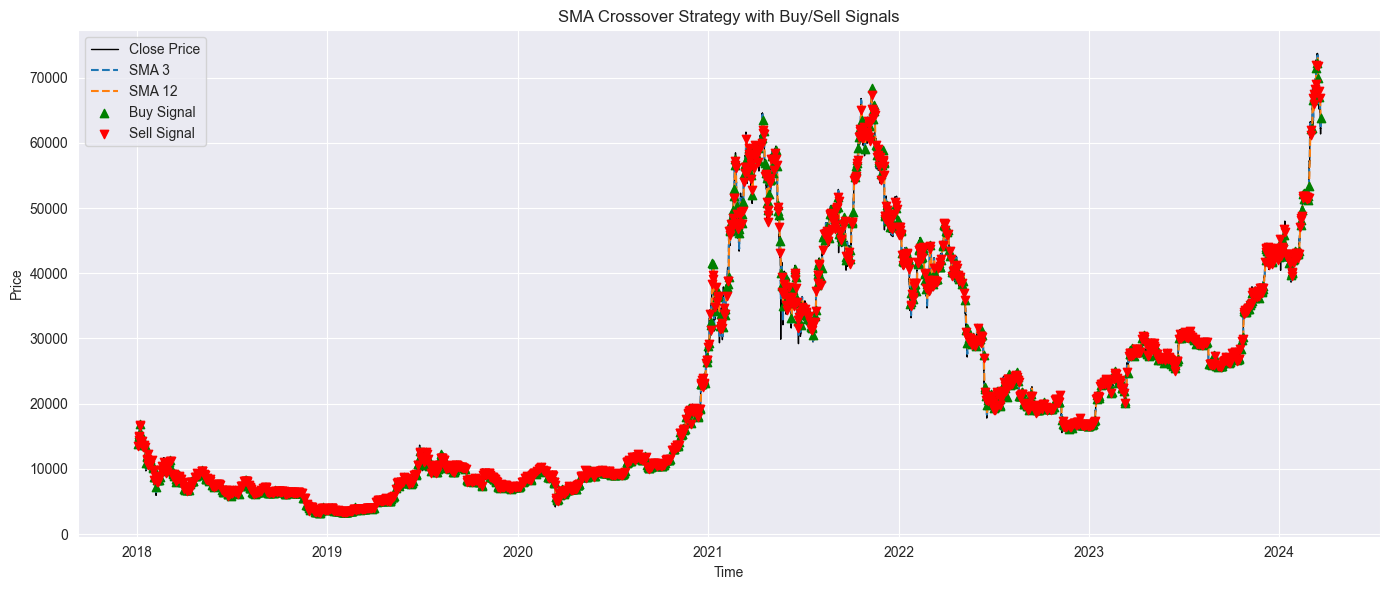

In [4]:
# Restrict the date range
start_date = '2018-01-01'
end_date = '2025-06-30'
final_df_limited = final_df.loc[start_date:end_date]
# Identify points where signal changes (crossovers)
signal_changes = final_df_limited['SMA_signal'].diff().fillna(0) != 0
buy_signals = final_df_limited[signal_changes & (final_df_limited['SMA_signal'] == 1)]
sell_signals = final_df_limited[signal_changes & (final_df_limited['SMA_signal'] == -1)]

# Visualization
plt.figure(figsize=(14, 6))
plt.plot(final_df_limited.index, final_df_limited['close'], label='Close Price', color='black', linewidth=1)
plt.plot(final_df_limited.index, final_df_limited['SMA_3'], label='SMA 3', linestyle='--')
plt.plot(final_df_limited.index, final_df_limited['SMA_12'], label='SMA 12', linestyle='--')

# Mark crossover signals
plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='green', label='Buy Signal', zorder=5)
plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='red', label='Sell Signal', zorder=5)

plt.title("SMA Crossover Strategy with Buy/Sell Signals")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Creating Labels

In [5]:
# close = prices['close']
# close = close.loc[start_date:end_date]
# trend_labels = mf.trend_labels(close,(5,20),look_forward=True)
# trend_labels
#trend_labels.to_csv('trend_labels_5_20_True.csv')

In [6]:
trend_labels=pd.read_csv('trend_labels_5_20_True.csv',parse_dates=True,index_col=0)
final_df_labeled = final_df_limited.join(trend_labels[['bin']], how='left')
final_df_labeled

,close,SMA_3,SMA_12,SMA_signal,volatility_6h_signal,log_ret,bin
date,,,,,,,
2018-01-01 01:00:00,13680.0,NaN,NaN,0,NaN,NaN,1.0
2018-01-01 02:00:00,13514.0,NaN,NaN,0,NaN,-0.012209,1.0
2018-01-01 03:00:00,13560.2,NaN,NaN,0,NaN,0.003413,-1.0
2018-01-01 04:00:00,13667.4,NaN,NaN,0,NaN,0.007874,-1.0
2018-01-01 05:00:00,13765.0,NaN,NaN,0,NaN,0.007116,-1.0
...,...,...,...,...,...,...,...
2024-03-20 12:00:00,63701.9,62644.800000,63151.387500,-1,-0.215392,0.009470,NaN
2024-03-20 13:00:00,63764.1,62971.450000,63158.308333,-1,-0.524426,0.000976,NaN
2024-03-20 14:00:00,63865.9,63247.100000,63173.779167,1,-1.123813,0.001595,NaN


# 3. Model Development

## 3.1 variables selection and parameters setting

In [45]:
x_variables = final_df_labeled[['SMA_signal','volatility_6h_signal']]
y_variables = final_df_labeled['bin'].dropna(how='all')
x_variables = sm.add_constant(x_variables)  
x_variables=x_variables.dropna()
x_variables

,const,SMA_signal,volatility_6h_signal
date,,,
2018-01-03 06:00:00,1.0,1,-0.495030
2018-01-03 07:00:00,1.0,1,-0.757322
2018-01-03 08:00:00,1.0,1,0.119106
2018-01-03 09:00:00,1.0,1,-0.047376
2018-01-03 10:00:00,1.0,1,-0.032358
...,...,...,...
2024-03-20 12:00:00,1.0,-1,-0.215392
2024-03-20 13:00:00,1.0,-1,-0.524426
2024-03-20 14:00:00,1.0,1,-1.123813


In [8]:
final_df_labeled['bin']

date
2018-01-01 01:00:00    1.0
2018-01-01 02:00:00    1.0
2018-01-01 03:00:00   -1.0
2018-01-01 04:00:00   -1.0
2018-01-01 05:00:00   -1.0
                      ... 
2024-03-20 12:00:00    NaN
2024-03-20 13:00:00    NaN
2024-03-20 14:00:00    NaN
2024-03-20 15:00:00    NaN
2024-03-20 16:00:00    NaN
Name: bin, Length: 54496, dtype: float64

In [9]:
expanding_mean = pd.DataFrame(final_df.loc[start_date:,f"log_ret"].expanding(min_periods=1).mean()).dropna(how='all')
expanding_mean

,log_ret
date,
2018-01-01 02:00:00,-0.012209
2018-01-01 03:00:00,-0.004398
2018-01-01 04:00:00,-0.000307
2018-01-01 05:00:00,0.001549
2018-01-01 06:00:00,0.000977
...,...
2024-03-20 12:00:00,0.000028
2024-03-20 13:00:00,0.000028
2024-03-20 14:00:00,0.000028


In [ ]:
train_start = pd.Timestamp(x_variables.index[0])
train_end = pd.Timestamp('2020-01-05 23:00:00')  #initial training period
calib_start = pd.Timestamp('2020-01-06 00:00:00') 
calib_end = pd.Timestamp('2020-5-05 23:00:00') 
test_start = calib_end + pd.DateOffset(hour=1)

In [10]:
# # Record the cumulative sum of SSE
# SSE_model_cumsum = []
# SSE_historical_cumsum = []
# # Store the feature importance of every step
# feature_importance_per_step = []
# # Use Random Forest for prediction
# model = RandomForestClassifier(n_estimators=1, random_state=42, max_depth=1, min_samples_split=5, max_features=0.6)
# # Record the actual value, the value predicted by our strategy and historical_mean_strategy
# forest_results = []
# correct_predictions = []
# y_true_list = []
# y_pred_list = []
# # Get the index position
# index_position = y_variables.index.get_loc(test_start)
# # Store the summaries of model
# model_summaries = []
# n_obs = len(y_variables)
# for t in tqdm(range(index_position, n_obs), desc=f"Processing"):
#     # Use all the value to train up to time t
#     X_train = x_variables.iloc[:t]
#     y_train = y_variables.iloc[:t]
#     
#     
#     
#     # Get the next step t+1
#     X_test = x_variables.iloc[t:t+1]
#     if X_test.empty:
#          continue  # skip this step to avoid crash
#     y_actual = y_variables.iloc[t:t+1]
#     y_actual = y_actual.iloc[0]
#     # When the testing start
#     current_date = y_variables.index[t]
#     
#     #print(hist_mean)
#     #print(X_test.index[-1])
#     
#     #y_historical_mean = y_historical_mean_data.iloc[:t] #no longer used as it has been defined in the lasso stage
#     # Extract the raw value from expanding_mean at the current test index
#     y_historical_mean_raw = expanding_mean.loc[X_test.index[-1]]
#     
#     # Convert the single-value Series to a scalar
#     y_historical_mean_val = y_historical_mean_raw.item()  # .iloc[0] also works if needed
#     
#     # Convert to classification label: 1 if > 0, otherwise -1
#     y_historical_mean = 1 if y_historical_mean_val > 0 else -1
# #Align form previous selection. It only generate the hsitorical mean of that timepoint
#     
#     
#     # Get the variables that are picked up by LASSO (those are not NA)
#     selected_features = x_variables.loc[current_date].dropna().index.tolist()
#     #selected_features = all_features_df.loc[current_date].dropna().index.tolist() #get index names from a series
#     
#     
#     # selected only the features that have been picked up by LASSO 
#     if len(selected_features) > 0:
#         X_train_selected = X_train[selected_features]
#         X_test_selected = X_test[selected_features]
# 
#         # Train the regression model
#         model.fit(X_train_selected, y_train)
#         y_pred = model.predict(X_test_selected)[0]  # Get the single predicted value
#         # Get the feature importance
#         if hasattr(model, "feature_importances_"):  
#             feature_importance = model.feature_importances_
#         else:
#             print("Feature_importance_error")
# 
#         # Record the feature importance of this time step
#         feature_importance_per_step.append({
#             "Date": current_date,  # record the date
#             **dict(zip(selected_features, feature_importance))
#         })
#         
#         # calculate the forecasting error of our strategy
#         # forecast_error = float(y_actual - y_pred)
#         forecast_error = int(y_actual != y_pred)  
#         correct_predictions.append(int(y_actual == y_pred))
#         y_true_list.append(int(y_actual))
#         y_pred_list.append(int(y_pred))
#     else:
#         # If LASSO selected no features, take the expanding historical mean as prediction and it will also be used as error.
#         # Actually it never happens because the num of selected features is 0. So no further study to judge whether this approach is good or not until other priorities are done.
#         #forecast_error = float(y_actual -  y_historical_mean)
#         forecast_error = int(y_actual != y_historical_mean) 
#         correct_predictions.append(int(y_actual == y_historical_mean))
#         y_true_list.append(int(y_actual))
#         y_pred_list.append(int(y_pred))
# 
#     # Calculate the error of using a rolling historical mean to predict (benchmark error) 
#     #historical_mean_error = float(y_actual -  y_historical_mean)
#     historical_mean_error = int(y_actual != y_historical_mean) 
# 
#     # # Calculate the SSE 
#     # if t == index_position: #1st iteration
#     #     SSE_model_cumsum.append(forecast_error ** 2)
#     #     SSE_historical_cumsum.append(historical_mean_error ** 2)
#     # else:
#     #     SSE_model_cumsum.append(SSE_model_cumsum[-1] + forecast_error ** 2) #After 1st iteration
#     #     SSE_historical_cumsum.append(SSE_historical_cumsum[-1] + historical_mean_error ** 2) 
#         
#      # Record the result for every step
#     forest_results.append({
#         "Date": y_variables.index[t],
#         "ret_real": int(y_actual),
#         "ret_pred": int(y_pred),
#         "historical_mean":  y_historical_mean,
#         "accuracy": sum(correct_predictions) / len(correct_predictions)
#     })
#     
# forest_results=pd.DataFrame(forest_results)
# print("Confusion Matrix:")
# print(confusion_matrix(y_true_list, y_pred_list))
# 
# print("\nClassification Report:")
# print(classification_report(y_true_list, y_pred_list, digits=4))
# # Cum_SSE_diff_series = np.array(SSE_historical_cumsum)  - np.array(SSE_model_cumsum)

## 3.2 Model training

In [11]:
# 固定训练集区间
X_train = x_variables.loc[train_start:train_end]
y_train = y_variables.loc[train_start:train_end]

# 测试集起点位置
index_position = y_variables.index.get_loc(test_start)
n_obs = len(y_variables)

In [23]:
# 可选：交叉验证调参（或直接训练模型）
param_grid = {
    'n_estimators': [100],
    'max_depth': [5, 10],
    'min_samples_split': [5, 10]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(
        random_state=42,
        max_features=0.6,
        class_weight='balanced'  # 加这个！
    ),
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1
)


grid_search.fit(X_train, y_train)
model = grid_search.best_estimator_

# 初始化记录变量
forest_results = []
feature_importance_per_step = []
correct_predictions = []
y_true_list = []
y_pred_list = []

## 3.3 Calibration: From hard to soft classification

In [24]:
# 校准集（用来拟合校准器）
X_calib = x_variables.loc[calib_start:calib_end]
y_calib = y_variables.loc[calib_start:calib_end]

# 将已训练好的模型再用校准集进行校准
calibrated_model = CalibratedClassifierCV(
    estimator=model,       
    method='sigmoid',
    cv='prefit'            
)
calibrated_model.fit(X_calib, y_calib)


CalibratedClassifierCV(cv='prefit',
                       estimator=RandomForestClassifier(class_weight='balanced',
                                                        max_depth=10,
                                                        max_features=0.6,
                                                        min_samples_split=5,
                                                        random_state=42))

## 3.4 Model prediction

In [25]:
for t in tqdm(range(index_position, n_obs), desc="Rolling Prediction"):
    X_test = x_variables.iloc[t:t+1]
    if X_test.empty:
        continue

    y_actual = y_variables.iloc[t]
    current_date = y_variables.index[t]

    # 历史均值作为 baseline（已对其分类化）
    y_historical_mean_raw = expanding_mean.loc[X_test.index[-1]]
    y_historical_mean_val = y_historical_mean_raw.item()
    y_historical_mean = 1 if y_historical_mean_val > 0 else -1

    # 获取该时刻 LASSO 保留的特征
    selected_features = x_variables.loc[current_date].dropna().index.tolist()

    if len(selected_features) > 0:
        X_test_selected = X_test[selected_features]

        try:
            #如果是不加calibration，用下面的代码
            #y_pred = model.predict(X_test_selected)[0]
            proba = calibrated_model.predict_proba(X_test_selected)[0]
            if proba[1] > 0.51:
                y_pred = 1
            elif proba[1] < 0.49:
                y_pred = -1
            else:
                y_pred = 0  # uncertain zone


            # 记录正确性
            correct_predictions.append(int(y_actual == y_pred))
            y_true_list.append(int(y_actual))
            y_pred_list.append(int(y_pred))

            # 如果模型支持 feature importance，可以记录
            if hasattr(model, "feature_importances_"):
                feature_importance = model.feature_importances_
                feature_importance_per_step.append({
                    "Date": current_date,
                    **dict(zip(X_train[selected_features].columns, feature_importance))
                })

        except Exception as e:
            print(f"Prediction error at {current_date}: {e}")
            continue
    else:
        # fallback：使用历史均值分类结果
        y_pred = y_historical_mean
        correct_predictions.append(int(y_actual == y_pred))
        y_true_list.append(int(y_actual))
        y_pred_list.append(int(y_pred))

    forest_results.append({
        "Date": current_date,
        "ret_real": int(y_actual),
        "ret_pred": int(y_pred),
        "historical_mean": y_historical_mean,
        "accuracy": sum(correct_predictions) / len(correct_predictions)
    })


Rolling Prediction: 100%|██████████| 33957/33957 [06:16<00:00, 90.09it/s] 


# 4. Feature Importance Analysis

## 4.1 In-sample: MDI

volatility_6h_signal    0.924104
SMA_signal              0.075896
const                   0.000000
dtype: float64


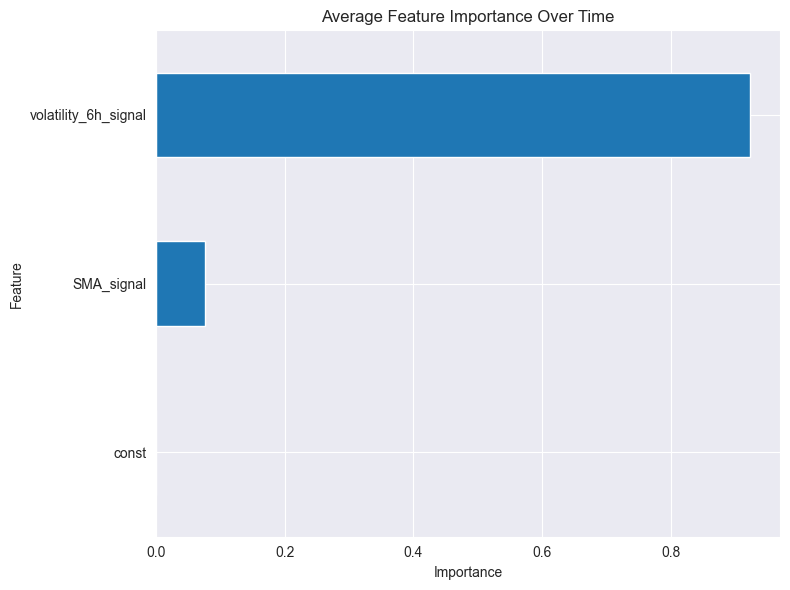

In [30]:
feature_importance_df = pd.DataFrame(feature_importance_per_step)
feature_importance_df.set_index("Date", inplace=True)
# 查看每个特征的平均重要性（跨时间）
mean_importance = feature_importance_df.mean().sort_values(ascending=False)
print(mean_importance)

mean_importance = feature_importance_df.mean().sort_values(ascending=True)

plt.figure(figsize=(8, 6))
mean_importance.plot(kind="barh")
plt.title("Average Feature Importance Over Time")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## 4.2 Out-of-sample: PFI

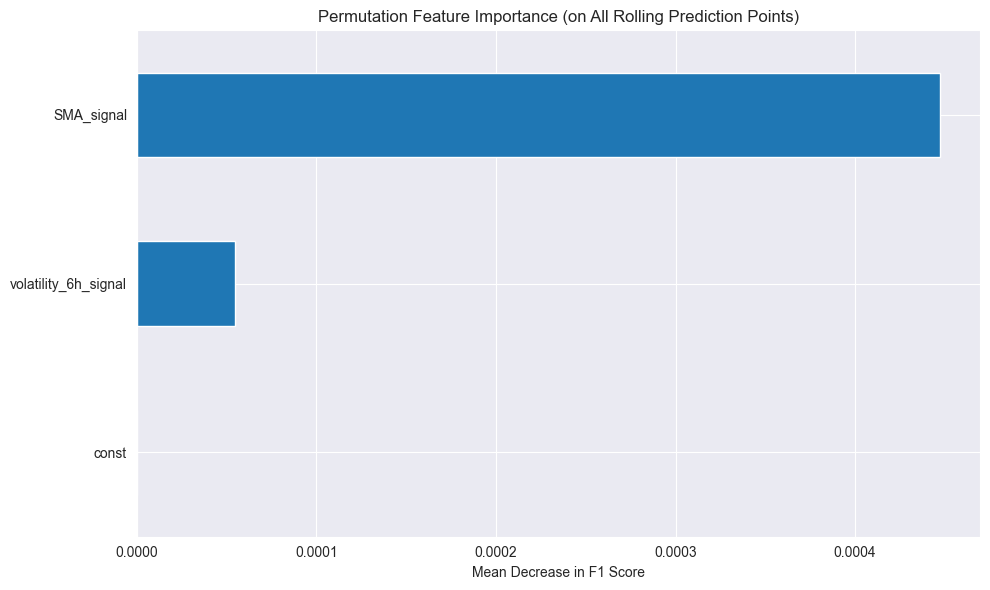

In [43]:
# 用 forest_results 的索引作为验证时间点
valid_dates = forest_results.index

# 构建验证集（特征 & 标签）
X_val_full = x_variables.loc[valid_dates]
y_val_full = y_variables.loc[valid_dates]

# 确保列顺序完全一致（与训练集相同）
X_val_full = X_val_full[X_train.columns].dropna()
y_val_full = y_val_full.loc[X_val_full.index]


result = permutation_importance(
    estimator=calibrated_model,
    X=X_val_full,
    y=y_val_full,
    n_repeats=10,
    scoring='f1',
    random_state=42
)

importances = pd.Series(result.importances_mean, index=X_val_full.columns)

plt.figure(figsize=(10, 6))
importances.sort_values(ascending=True).plot(kind="barh")
plt.title("Permutation Feature Importance (on All Rolling Prediction Points)")
plt.xlabel("Mean Decrease in F1 Score")
plt.tight_layout()
plt.show()



# 5. Model Evaluation

In [35]:
# 二分类
# forest_results = pd.DataFrame(forest_results)
# 
# print("\nConfusion Matrix:")
# print(confusion_matrix(y_true_list, y_pred_list))
# 
# print("\nClassification Report:")
# print(classification_report(y_true_list, y_pred_list, digits=4))
# 三分类

# 全部显示：混淆矩阵中保留 0 类
print("\nConfusion Matrix (with class 0 shown):")
print(confusion_matrix(y_true_list, y_pred_list, labels=[1, 0, -1]))

# 精度评估：只对 -1 和 1 做评分
print("\nClassification Report (excluding class 0):")
print(classification_report(y_true_list, y_pred_list, labels=[1, -1], digits=4))
print("\nY variable distribution")
print(y_train.value_counts(normalize=True))




Confusion Matrix (with class 0 shown):
[[16248  1189   146]
 [    0     0     0]
 [14982  1209   149]]

Classification Report (excluding class 0):
              precision    recall  f1-score   support

           1     0.5203    0.9241    0.6657     17583
          -1     0.5051    0.0091    0.0179     16340

   micro avg     0.5201    0.4834    0.5011     33923
   macro avg     0.5127    0.4666    0.3418     33923
weighted avg     0.5130    0.4834    0.3537     33923


# 6. Optional: Backtesting Performance

In [27]:
forest_results = pd.DataFrame(forest_results)
forest_results.set_index("Date", inplace=True)
log_ret_series = final_df_labeled["log_ret"]
forest_results = forest_results.join(log_ret_series, how="left")  # 按 forest_results 的索引合并
forest_results

,ret_real,ret_pred,historical_mean,accuracy,log_ret
Date,,,,,
2020-05-05 01:00:00,1,1,-1,1.000000,-0.005233
2020-05-05 02:00:00,1,1,-1,1.000000,-0.001104
2020-05-05 03:00:00,-1,1,-1,0.666667,-0.002212
2020-05-05 04:00:00,-1,1,-1,0.500000,0.008470
2020-05-05 05:00:00,-1,1,-1,0.400000,0.016342
...,...,...,...,...,...
2024-03-18 07:00:00,-1,1,1,0.483416,-0.002421
2024-03-18 08:00:00,-1,1,1,0.483402,-0.005312
2024-03-18 09:00:00,-1,1,1,0.483388,-0.004875


## 6.1 Return plots

### 6.1.1 Return plots without transaction costs

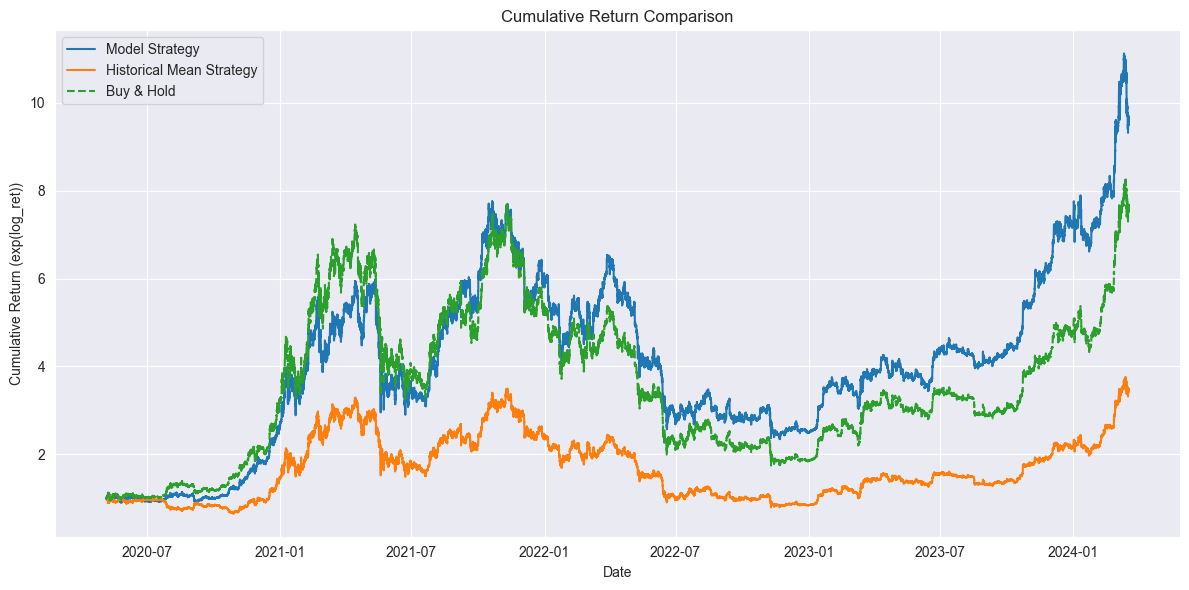

In [29]:
# Step 1: 创建新 DataFrame，索引与 forest_results 相同
returns_df = pd.DataFrame(index=forest_results.index)

# Step 2: 计算每个策略的即时收益
returns_df["strategy_ret"] = forest_results["ret_pred"] * forest_results["log_ret"]
returns_df["benchmark_ret"] = forest_results["historical_mean"] * forest_results["log_ret"]
returns_df["buy_and_hold"] = forest_results["log_ret"]

# Step 3: 计算累计收益（按 log return 累加再取 exp）
returns_df["cum_strategy_ret"] = (returns_df["strategy_ret"]).cumsum().apply(lambda x: (x)).apply(np.exp)
returns_df["cum_benchmark_ret"] = (returns_df["benchmark_ret"]).cumsum().apply(lambda x: (x)).apply(np.exp)
returns_df["cum_buy_and_hold"] = (returns_df["buy_and_hold"]).cumsum().apply(lambda x: (x)).apply(np.exp)

# Step 4: 绘图
plt.figure(figsize=(12, 6))
plt.plot(returns_df.index, returns_df["cum_strategy_ret"], label="Model Strategy")
plt.plot(returns_df.index, returns_df["cum_benchmark_ret"], label="Historical Mean Strategy")
plt.plot(returns_df.index, returns_df["cum_buy_and_hold"], label="Buy & Hold", linestyle='--')
plt.title("Cumulative Return Comparison")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (exp(log_ret))")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [31]:
forest_results

,ret_real,ret_pred,historical_mean,accuracy,log_ret
Date,,,,,
2020-05-05 01:00:00,1,1,-1,1.000000,-0.005233
2020-05-05 02:00:00,1,1,-1,1.000000,-0.001104
2020-05-05 03:00:00,-1,1,-1,0.666667,-0.002212
2020-05-05 04:00:00,-1,1,-1,0.500000,0.008470
2020-05-05 05:00:00,-1,1,-1,0.400000,0.016342
...,...,...,...,...,...
2024-03-18 07:00:00,-1,1,1,0.483416,-0.002421
2024-03-18 08:00:00,-1,1,1,0.483402,-0.005312
2024-03-18 09:00:00,-1,1,1,0.483388,-0.004875


### 6.1.2 Return plots with transaction costs

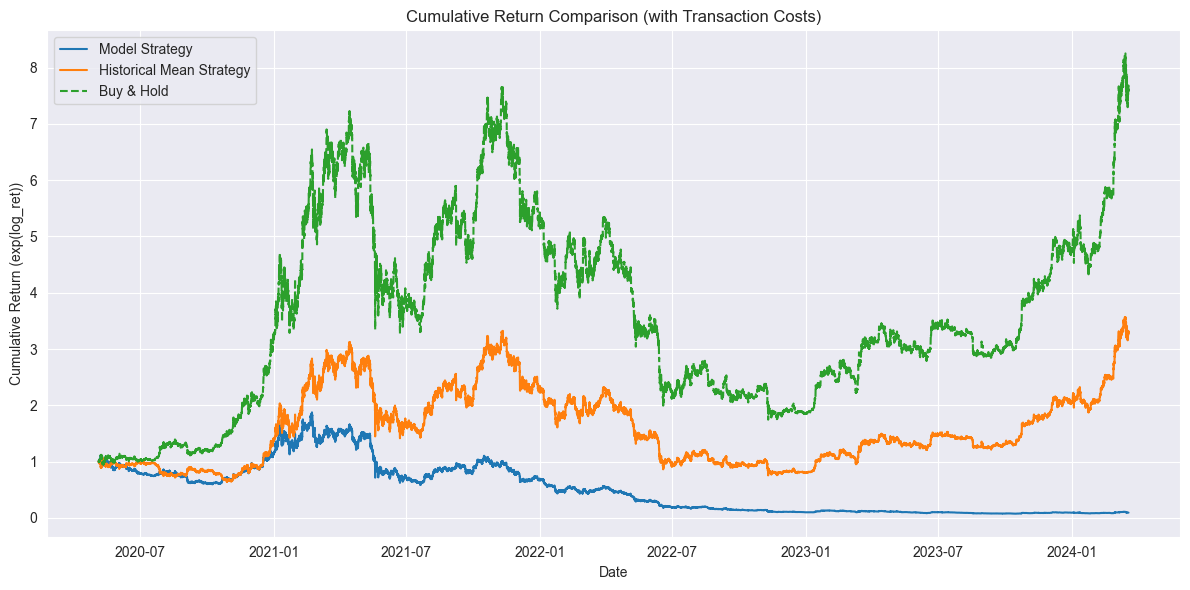

In [32]:
# 设置交易成本
transaction_cost = 0.001

# Step 1: 创建新 DataFrame，索引与 forest_results 相同
returns_df = pd.DataFrame(index=forest_results.index)

# Step 2: 添加信号列
returns_df["ret_pred"] = forest_results["ret_pred"]
returns_df["historical_mean"] = forest_results["historical_mean"]
returns_df["log_ret"] = forest_results["log_ret"]

# Step 3: 计算仓位变化（第一个为 0）
returns_df["strategy_position_change"] = (
    (returns_df["ret_pred"] != returns_df["ret_pred"].shift(1)).astype(int) +
    ((returns_df["ret_pred"] * returns_df["ret_pred"].shift(1)) == -1).astype(int)
).fillna(0).astype(int)

returns_df["historical_position_change"] = (
    (returns_df["historical_mean"] != returns_df["historical_mean"].shift(1)).astype(int) +
    ((returns_df["historical_mean"] * returns_df["historical_mean"].shift(1)) == -1).astype(int)
).fillna(0).astype(int)

# Step 4: 计算即时收益（扣除交易成本）
returns_df["strategy_ret"] = returns_df["ret_pred"] * returns_df["log_ret"] - transaction_cost * returns_df["strategy_position_change"]
returns_df["benchmark_ret"] = returns_df["historical_mean"] * returns_df["log_ret"] - transaction_cost * returns_df["historical_position_change"]
returns_df["buy_and_hold"] = returns_df["log_ret"]

# Step 5: 计算累计收益（按 log return 累加再取 exp）
returns_df["cum_strategy_ret"] = returns_df["strategy_ret"].cumsum().apply(np.exp)
returns_df["cum_benchmark_ret"] = returns_df["benchmark_ret"].cumsum().apply(np.exp)
returns_df["cum_buy_and_hold"] = returns_df["buy_and_hold"].cumsum().apply(np.exp)

# Step 6: 绘图
plt.figure(figsize=(12, 6))
plt.plot(returns_df.index, returns_df["cum_strategy_ret"], label="Model Strategy")
plt.plot(returns_df.index, returns_df["cum_benchmark_ret"], label="Historical Mean Strategy")
plt.plot(returns_df.index, returns_df["cum_buy_and_hold"], label="Buy & Hold", linestyle='--')
plt.title("Cumulative Return Comparison (with Transaction Costs)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (exp(log_ret))")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
returns_df

,ret_pred,historical_mean,log_ret,strategy_position_change,historical_position_change,strategy_ret,benchmark_ret,buy_and_hold,cum_strategy_ret,cum_benchmark_ret,cum_buy_and_hold
Date,,,,,,,,,,,
2020-05-05 01:00:00,1,-1,-0.005233,1,1,-0.006233,0.004233,-0.005233,0.993787,1.004242,0.994781
2020-05-05 02:00:00,1,-1,-0.001104,0,0,-0.001104,0.001104,-0.001104,0.992690,1.005351,0.993683
2020-05-05 03:00:00,1,-1,-0.002212,0,0,-0.002212,0.002212,-0.002212,0.990497,1.007577,0.991488
2020-05-05 04:00:00,1,-1,0.008470,0,0,0.008470,-0.008470,0.008470,0.998922,0.999079,0.999922
2020-05-05 05:00:00,1,-1,0.016342,0,0,0.016342,-0.016342,0.016342,1.015381,0.982884,1.016397
...,...,...,...,...,...,...,...,...,...,...,...
2024-03-18 07:00:00,1,1,-0.002421,0,0,-0.002421,-0.002421,-0.002421,0.092770,3.313925,7.665849
2024-03-18 08:00:00,1,1,-0.005312,0,0,-0.005312,-0.005312,-0.005312,0.092279,3.296369,7.625238
2024-03-18 09:00:00,1,1,-0.004875,0,0,-0.004875,-0.004875,-0.004875,0.091830,3.280338,7.588155


## 6.2 Strategy performance matrices

In [36]:
# 年化无风险收益率（3%），换算为每小时
annual_risk_free_rate = 0.03
hourly_risk_free_rate = np.log(1 + annual_risk_free_rate) / (252 * 24)  # 假设252个交易日 × 每天24小时

def calculate_sharpe_ratio(hourly_returns, risk_free_rate=hourly_risk_free_rate):
    """计算年化Sharpe Ratio"""
    excess_returns = hourly_returns - risk_free_rate
    annualized_excess_return = excess_returns.mean() * 252 * 24
    annualized_std = hourly_returns.std() * np.sqrt(252 * 24)
    return annualized_excess_return / annualized_std if annualized_std != 0 else np.nan

def calculate_max_drawdown(cumulative_returns):
    """计算最大回撤"""
    peak = np.maximum.accumulate(cumulative_returns)
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

def calculate_win_rate(returns):
    """胜率（正收益比例）"""
    return (returns > 0).sum() / len(returns)


In [37]:
results_summary = {}

for strategy_name in ["strategy_ret", "benchmark_ret", "buy_and_hold"]:
    ret = returns_df[strategy_name]
    cum_ret = ret.cumsum().apply(np.exp)

    sharpe = calculate_sharpe_ratio(ret)
    drawdown = calculate_max_drawdown(cum_ret)
    win_rate = calculate_win_rate(ret)

    results_summary[strategy_name] = {
        "Sharpe Ratio": sharpe,
        "Max Drawdown": drawdown,
        "Win Rate": win_rate
    }

# 展示结果
summary_df = pd.DataFrame(results_summary).T
print(summary_df)


               Sharpe Ratio  Max Drawdown  Win Rate
strategy_ret      -0.846104     -0.961138  0.464552
benchmark_ret      0.324735     -0.773097  0.503375
buy_and_hold       0.589890     -0.773097  0.508180
